In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
print("Sentiment Count")
print(train.Sentiment.value_counts())
train.sample(20)

Sentiment Count
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


,PhraseId,SentenceId,Phrase,Sentiment
100376,100377,5267,itself -- as well its delightful cast -- is so...,3
148511,148512,8080,just not,2
47376,47377,2310,pulls no punches in its depiction of the lives...,3
41037,41038,1967,female condition,2
74285,74286,3805,month 's,2
10456,10457,440,European,2
98964,98965,5190,stunt-hungry dimwits,1
37596,37597,1787,"Clockstoppers is one of those crazy , mixed-up...",1
130092,130093,7007,"will no doubt rally to its cause , trotting ou...",1
57690,57691,2908,'s worked too hard on this movie,1


## 1. 数据预处理
1. 统计单词频率并保留频率最高的100000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [3]:
# 探索阶段，可放开以下注释，仅使用头1000行数据
# train = train.head(1000)

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = str(sentence).split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))
top_k_words = 100000
# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>', '<PAD>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 16531


2. 构建基于词序号的数据集，为词向量做准备

In [4]:
# 处理句子数据
def preprocess_sentence(sentence,  word2idx, max_len):
    x = np.ones(max_len,dtype=np.int64)*word2idx['<PAD>'] # 默认全部为填充词<PAD>
    words = sentence.split()
    words = [w.lower() for w in words][:max_len]
    for i,w in enumerate(words):
        if w in word2idx:
            x[i]=word2idx[w]
        else:
            x[i]=word2idx['<UNK>']
    return x

# 处理语料库
def extract_word_index_feat(df, word2idx, max_len=40):
    X = []
    for sentence in df.Phrase:
        x = preprocess_sentence(sentence, word2idx, max_len)
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y

X,y = extract_word_index_feat(train, word2idx)

# 数据集结构定义
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# 数据集划分
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]


# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 2. 模型

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# 加载GloVe词向量
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# 模型定义
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, vocab_size, embedding_dim, glove_file_path, idx2word):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(embedding_dim * input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  

        # Initialize the embedding layer with pre-trained GloVe embeddings
        glove_embeddings = load_glove_embeddings(glove_file_path)
        weight_matrix = np.zeros((vocab_size, embedding_dim))
        for i, word in enumerate(idx2word):
            if word in glove_embeddings:
                weight_matrix[i] = glove_embeddings[word]
        self.embedding.weight = nn.Parameter(torch.tensor(weight_matrix, dtype=torch.float32))

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

# 创建模型实例
model = MLP(input_dim=40, hid_dim=100, output_dim=5, 
            vocab_size=len(idx2word), embedding_dim=50, 
            glove_file_path='../../assignment1_glove/glove.6B.50d.txt', idx2word=idx2word)

## 3. 学习准则（策略）

In [6]:
# 交叉熵
criterion = nn.CrossEntropyLoss()

## 4. 优化（算法）

In [7]:
# 随机梯度下降算法SGD的变种
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. 训练过程

In [8]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [] # 训练损失
val_losses = [] # 验证损失
train_accuracies = [] # 训练精度
val_accuracies = [] # 验证精度
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 计算设备使用GPU或CPU（GPU优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练多个回合
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = (train_correct / len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # 打印训练和验证的损失和精度
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Loss: 1.3123, Val Loss: 1.3156, Train Acc: 58.47%, Val Acc: 58.09%
Epoch 2/10, Loss: 1.2519, Val Loss: 1.3103, Train Acc: 64.89%, Val Acc: 58.76%
Epoch 3/10, Loss: 1.2245, Val Loss: 1.3090, Train Acc: 67.80%, Val Acc: 58.97%
Epoch 4/10, Loss: 1.2055, Val Loss: 1.3124, Train Acc: 69.81%, Val Acc: 58.69%
Epoch 5/10, Loss: 1.1906, Val Loss: 1.3142, Train Acc: 71.29%, Val Acc: 58.53%
Epoch 6/10, Loss: 1.1785, Val Loss: 1.3158, Train Acc: 72.56%, Val Acc: 58.41%
Epoch 7/10, Loss: 1.1705, Val Loss: 1.3176, Train Acc: 73.37%, Val Acc: 58.29%
Epoch 8/10, Loss: 1.1633, Val Loss: 1.3198, Train Acc: 74.09%, Val Acc: 58.10%
Epoch 9/10, Loss: 1.1580, Val Loss: 1.3205, Train Acc: 74.63%, Val Acc: 58.03%
Epoch 10/10, Loss: 1.1533, Val Loss: 1.3198, Train Acc: 75.09%, Val Acc: 58.17%


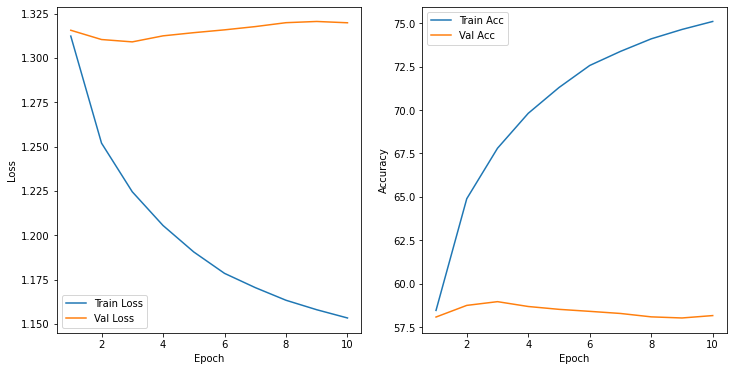

In [9]:
# 对训练和验证集上的损失和精度按照回合数进行可视化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('loss_acc_plot.png')
plt.show()

## 6. 测试
测试结果可提交后查看精度表现
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews## 生成测试结果

In [10]:
test = pd.read_csv('test.tsv', sep='\t')
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_word_index_feat(test, word2idx)
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.append(predicted.cpu().numpy())
y_test = np.concatenate(all_predicted)
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_wordemb_MLP.csv', index=False)

In [11]:
!ls

Sentiment_BoW_MLP.csv                 sentiment_wordemb_mlp_gloveinit.ipynb
Sentiment_wordemb_MLP.csv             test.tsv
loss_acc_plot.png                     train.tsv
sentiment_bow_mlp.py                  学号_姓名_sentiment_bow_mlp.ipynb
sentiment_wordemb_mlp.ipynb
